In [1]:
# various modules used here.
from matplotlib import gridspec
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.ndimage.filters import gaussian_filter1d

import scipy.stats as stats
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
import scipy
import glob
import yaml
import pylab
import polo
import pandas
import re

In [2]:
report = {}

154.935 267.615


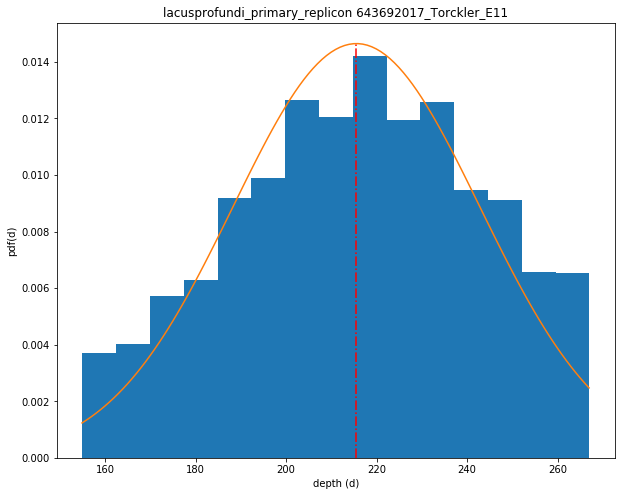

In [328]:
# The following was applied manually for each organism directory, where some adjustments were made
# due to sensitivity to the extracted ranges. Not a perfect algorithm.

# scan over the directories for coverage files
for fn in glob.glob('lacusprofundi_primary_replicon/*.txt'):
    # read the data file
    org, smpl = fn.split('/')
    # remove the suffix
    smpl = smpl[:-len('_coverage.txt')]
    
    this_report = {}
    report.setdefault(org, {})[smpl] = this_report
    
    d = pd.read_csv(fn, delimiter='\t', names=['_','x','depth'])
    this_report['med_depth'] = float(np.median(d.depth))
    
    # create a histogram and determine the mode
    h = np.histogram(d.depth, bins=200)
    max_i = np.argmax(h[0])
    
    # to avoid fitting issues, we'll walk back either side of the
    # peak to find a range on which to fit our gaussian
    thres = 0.33
    
    max_v = h[0][max_i]
    li = ui = max_i
    while li >= 0 and ui < len(h[0]):
        if h[0][li] < thres*max_v or h[0][ui] < thres*max_v:
            break
        li -= 1
        ui += 1
        
    if li < 0:
        li = 0
    if ui >= len(h[0]):
        ui = len(h[0])-1
    
    # lower/upper bound values
    lb = h[1][li]
    ub = h[1][ui]
    print lb, ub
    
    this_report['bounds'] = [float(lb), float(ub)]
    
    # select only those data points between the determined bounds
    ix = (d.depth>lb) & (d.depth<ub)
    subrng = d.depth[ix]

    # fit a gaussian to this sub-range
    # assume the median as a starting point for the mean of the curve
    params = stats.norm.fit(subrng, loc=this_report['med_depth'], scale=1.0)
    this_report['fit'] = [float(v) for v in params]

    # comparison plot of data to estimated distribution
    pdf = stats.norm.pdf(np.arange(lb,ub), *params)
    plt.figure(figsize=(10, 8))
    plt.title('{} {}'.format(org,smpl))
    plt.xlabel('depth (d)')
    plt.ylabel('pdf(d)')
    plt.hist(subrng, normed=True, bins=15)
    plt.plot(np.arange(lb,ub), pdf)
    plt.vlines(params[0], 0, np.max(pdf), colors='red', linestyles='-.')
    plt.savefig('{}-{}.png'.format(org, smpl))
    plt.show()
    plt.close()
    

In [329]:
# this was used to write out all the peak fitting results to a YAML format file.
# YAML can be read by many languages and packages.
with open('all_report.yaml', 'w') as out_h:
    yaml.dump(report, out_h, default_flow_style=False)

In [2]:

def binning(data, step):
    """
    Bin an array by step width, report the median of each bin
    """
    meds = []
    c = []
    n = 0
    bins = []
    for ir in xrange(data.shape[0]):
        if data[ir, 0] > (n+1)*step:
            meds.append(np.median(c))
            bins.append((n+1)*step)
            n += 1
            c = []
        else:
            c.append(data[ir, 1])
    return np.array(meds), np.array(bins)

def run_hclust(outname, meds, bins, step_size, tick_spc, savePlot=False):
    """
    Cluster and plot the binned data matrix.
    """
    
    # just for indexing
    names = meds.columns
    
    # normalise rows by their median value
    D = meds.as_matrix().T
    D = (D.T/np.median(D, 1)).T
    # center rows on their medians
    D = (D.T - np.median(D, 1)).T
    
    # clustering options. We will use correlation as measure of distance
    # and complete linkage clustering
    metric = 'correlation'
    method = 'complete'
    
    # calculate
    Y = linkage(D, method=method, metric=metric)
    
    # additionally, find optimal leaf ordering
    Yopt = polo.optimal_leaf_ordering(Y, pdist(D, metric=metric))

    # now we do some plotting
    fig = plt.figure(figsize=(12, 8), dpi=150)
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 2], height_ratios= [0.6,10]) 
    gs.update(wspace=0.08)

    axmatrix = plt.subplot(gs[2])
    axmatrix.set_xlabel('genomic coord (kbp)')
    axcolor = plt.subplot(gs[0])
    axcolor.set_title('median centered relative abundance ')
    axdend = plt.subplot(gs[3])
    axdend.set_xlabel('dist')

    # calculate and plot the dendrogram
    Z = dendrogram(Yopt, ax=axdend, orientation='right', no_labels=True, color_threshold=0 )
    
    # the tips (leaves) of the tree become the order for rows
    idx = Z['leaves']
    
    # reorder rows
    D = D[idx, :]

    # the largest value in the matrix will set the upper and lower bounds
    # for the heatmap color-range. This assures 0 as the center.
    vmin = D.min() * 1.05
    vmax = -vmin
    
    # plot the matrix, 5% extra bounds above and below on colour range
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.RdBu_r, \
                          norm=colors.Normalize(vmin=vmin, vmax=vmax) )

    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # try and get some useful axis labels
    #xticks = np.linspace(0, max(bins) - max(bins) % step_size, 5)
    #print xticks
    
    xticks = np.arange(0, len(bins), tick_spc) # every 100 bins
    axmatrix.set_xticks(xticks)
    axmatrix.set_xticklabels(xticks * step_size/1000)
    axmatrix.set_yticks(range(D.shape[0]))
    axmatrix.set_yticklabels(np.array(names)[idx], minor=False, )
    axmatrix.xaxis.set_label_position('bottom')
    axmatrix.xaxis.tick_bottom()

    # Plot colorbar.
    pylab.colorbar(im, cax=axcolor, orientation='horizontal')
    
    if savePlot:
        plt.savefig('{}_hclust.pdf'.format(outname), bbox_inches='tight')
        pd.DataFrame(D.T, columns=names).to_csv('{}_dat.csv'.format(outname))
    else:
        plt.show()
        
    plt.close()


In [3]:
# read in the per-position coverage data for each sample and bin to a corser size
def get_block_medians(glob_path, step_size):

    meds = []
    bins = []
    smpl_names = []

    # manually parse each organism directory. Manually meaning, change this path
    # for each one. Could be made a loop, but unnecessary for 3 runs
    for fn in glob.glob(glob_path):
        print fn

        # read the data file
        smpl = fn.split('/')[-1][:-len('_coverage.txt')]
        smpl_names.append(smpl)

        data = pd.read_csv(fn, delimiter='\t', names=['_','x','depth'])
        data = data.as_matrix()[:, 1:]
        m, b = binning(data, step_size)
        meds.append(m)
        bins.append(b)

    return pandas.DataFrame(np.vstack(meds).T, columns=smpl_names), bins



In [4]:
# working file names to publication names

name_map = {'DL2006': 'Deep Lake 2006',
'DL2008': 'Deep Lake 2008',
'DL2013_Dec': 'Deep Lake 2013',
'DL2014_Dec':'Deep Lake 2014',
'DL2014_Jun': 'Deep Lake 2014 winter',
'Club':'Club Lake',
'Filla_3': 'Rauer 3 Lake',
'Torckler_E6': 'Rauer 6 Lake',
'Torckler_E11': 'Rauer 13 Lake'}


In [7]:
# prepare dataframe for publication.
# throw an error if we did not rename 9 columns

# remove the unwanted location
for cn in meds.columns:
    if re.match('.*Filla_E10.*',cn):
        print 'Removing Filla_E10'
        meds.drop(cn, axis=1, inplace=True)
        break

# rename the remainder
new_names = []
for cn in meds.columns:
    for on in name_map:
        p = '.*{}'.format(on)
        m = re.match(p, cn)
        if m:
            print '{} renamed to {}'.format(cn, on)
            new_names.append(name_map[on])
            break

if len(new_names) != 9:
    raise RuntimeError('wrong number of columns')

meds.columns = new_names


Removing Filla_E10
2506841506_Club renamed to Club
2506841506_DL2006 renamed to DL2006
2506841506_DL2008 renamed to DL2008
2506841506_DL2013_Dec renamed to DL2013_Dec
2506841506_DL2014_Dec renamed to DL2014_Dec
2506841506_DL2014_Jun renamed to DL2014_Jun
2506841506_Filla_3 renamed to Filla_3
2506841506_Torckler_E11 renamed to Torckler_E11
2506841506_Torckler_E6 renamed to Torckler_E6


In [5]:
# various statistics calculated above and saved in YAML format
dat = yaml.load(open('all_report.yaml','r'))

In [11]:
# bp window size
step = 5000

# calculate the bins
meds, bins = get_block_medians('../lacusprofundi_primary_replicon/*', step_size=step)

../lacusprofundi_primary_replicon/643692017_Club_coverage.txt
../lacusprofundi_primary_replicon/643692017_DL2006_coverage.txt
../lacusprofundi_primary_replicon/643692017_DL2008_coverage.txt
../lacusprofundi_primary_replicon/643692017_DL2013_Dec_coverage.txt
../lacusprofundi_primary_replicon/643692017_DL2014_Dec_coverage.txt
../lacusprofundi_primary_replicon/643692017_DL2014_Jun_coverage.txt
../lacusprofundi_primary_replicon/643692017_Filla_3_coverage.txt
../lacusprofundi_primary_replicon/643692017_Filla_E10_coverage.txt
../lacusprofundi_primary_replicon/643692017_Torckler_E11_coverage.txt
../lacusprofundi_primary_replicon/643692017_Torckler_E6_coverage.txt


In [12]:
# perform hclust and plot
run_hclust('lacus_5kb', meds, bins[0], step, 100, savePlot=True)

In [4]:
#
#
# unused methods
#
#

def find_windows(x, mu, sig, smfac):
    thres = mu - 3 * sig
    d = gaussian_filter1d(x, sigma=smfac)
    
    #plt.figure(figsize=(14,6))
    plt.plot(np.arange(len(d))*50,d)
    plt.hlines(y=thres, xmin=0, xmax=len(d)*50, colors='red')
    plt.ylim(0, mu+2*sig)
    #plt.show()
    
    #print d, thres_min
    x = np.where(d < thres)[0]
    dx = np.diff(x)
    # print d
    # print x
    # print dx

    windows = []
    n = 0
    a = 0
    for i in xrange(len(dx)):
        if dx[i] == 1:
            n += 1
            if a == None:
                a = i
        else:
            if n == 0:
                continue
            # print a, n, x[a:a+n], x[[a,a+n]], d[x[a:a+n]]
            windows.append(x[[a,a+n]])
            a = None
            n = 0
    
    if n > 0:
        windows.append(x[[a,a+n]])
            
    return np.array(windows)

# block size used in median filter
block_size = 50

# window size in bp
min_window = 1000

genome = 'lacusprofundi_primary_replicon'

# chr of interest
samples = dat[genome]

# per-sample list of windows to concatenate at the end
dataframes = []

# set up the big plot space
plt.figure(1, figsize=(14,4*len(samples)))

# for each smpl in the data set of the given genome
for n, smpl in enumerate(meds.columns, 1):
    
    # from the report, get the mean and sigma for thresholding
    mu = samples[smpl]['fit'][0]
    sig = samples[smpl]['fit'][1]

    plt.subplot(len(samples),1,n)
    plt.title('{} --- mu={:.2f} sig={:.2f} thres={:.2f}'.format(smpl, mu, sig, mu-3*sig))
    
    # determine windows, with a small amount of smoothing.
    w = find_windows(meds[smpl], mu, sig, 20)
    # adjust window ranges to bp values
    w *= block_size
    
    # indices of only those windows > min_window
    if len(w) == 0:
        print 'no windows found'
        continue

    ix = (np.diff(w, axis=1).T >= min_window)[0]
    
    # create and store a dataframe of these windows in the sample
    wins = np.hstack((w[ix], (w[ix,1] - w[ix,0])[:,np.newaxis]))
    rownames = ['{} window:{}'.format(smpl, i) for i in xrange(1,len(wins)+1)]
    dataframes.append(pandas.DataFrame(wins, columns=['begin','end','length'], index=rownames))


# save plots
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.savefig('{}_windows.pdf'.format(genome))
plt.close()

# save table of windows
df = pandas.concat(dataframes)
df.to_csv('{}_windows.csv'.format(genome))


NameError: name 'dat' is not defined